In [17]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import inception_v3


base_image_path = keras.utils.get_file("yeni.jpg", "https://images.unsplash.com/photo-1474418397713-7ede21d49118?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=736&q=80")
result_prefix = "yeni_dream"

#bunlar aktivasyonu en üst düzeyde çıkarmaya çalıştıgımız katmanların adıları
#ve en üst düzeye çıkarmaya çalıştıgımız son kayıptaki ağırlıklardır
#yeni görsel efeker elde etmek için bu ayarı düzelen
layer_settings={
    "mixed4":2.0,
    "mixed5":3.5,
    "mixed6":2.0,
    "mixed7":3.5,
}
# Bu hiperparametrelerle oynamak da yeni efektler elde etmenizi sağlar
step=0.01#gradyan cıkış adımım
num_octave=3#ölvek sayisi
octave_scale=1.4#olcek boyut
iteration=20 #olcek başına çıkış adımı sayisi
max_loss=15.0


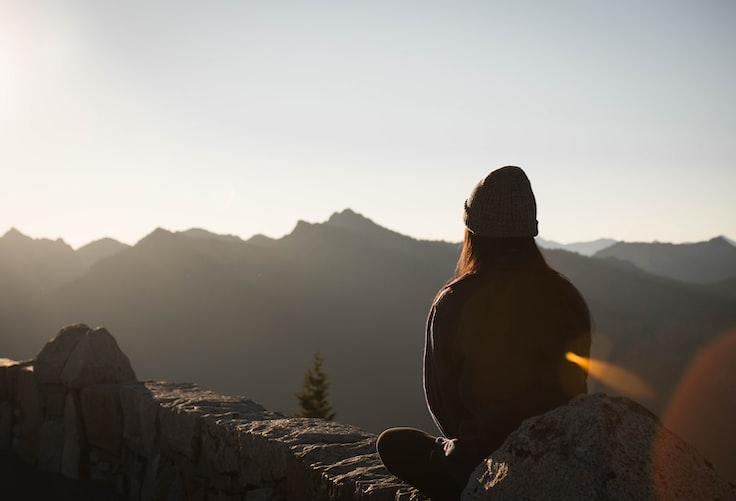

In [18]:
from IPython.display import Image,display
display(Image(base_image_path))

In [19]:
def preprocess_image(image_path):
    # Resimleri uygun dizilere açmak, yeniden boyutlandırmak ve biçimlendirmek için Util işlevi
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # NumPy dizisini geçerli bir görüntüye dönüştürmek için Util işlevi.
    x = x.reshape((x.shape[1], x.shape[2], 3))
    # Inceptionv3 ön işlemesini geri alma
    x /= 2.0
    x += 0.5
    x *= 255.0
    # Convert to uint8 and clip to the valid range [0, 255]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [20]:
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

# Her "anahtar" katmanın sembolik çıktılarını alın
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)

# Her hedef katman için etkinleştirme değerlerini döndüren bir model oluşturun (dict olarak)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [21]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    # Kaybı başlat
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # Sınırda olmayan pikselleri yalnızca kayda dahil ederek kenarlık yapaylıklarından kaçınırız.
        scaling = tf.reduce_prod(tf.cast(tf.shape(activation), "float32"))
        loss += coeff * tf.reduce_sum(tf.square(activation[:, 2:-2, 2:-2, :])) / scaling
    return loss

In [22]:
@tf.function
def gradient_ascent_step(img, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img)
    # Gradyanları Hesapla.
    grads = tape.gradient(loss, img)
    # Gradyanları Normalize Et.
    grads /= tf.maximum(tf.reduce_mean(tf.abs(grads)), 1e-6)
    img += learning_rate * grads
    return loss, img


def gradient_ascent_loop(img, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, img = gradient_ascent_step(img, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print("... Loss value at step %d: %.2f" % (i, loss))
    return img

In [23]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]
shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print("Processing octave %d with shape %s" % (i, shape))
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img(result_prefix + ".png", deprocess_image(img.numpy()))

Processing octave 0 with shape (255, 375)


NameError: ignored

In [ ]:
display(Image(result_prefix + ".png"))